In [1]:
import pandas as pd
import numpy as np
from typing import List
import bitstring
from joblib import Parallel, delayed
from helper_functions import compare_3d_lists, runtime_analysis_between_two_functions, read_dataframe, display_images

# Our Old Code

In [2]:
def convert_samples_to_binary(df: pd.DataFrame, precision: 32 or 64 = 64, one: int = 128, zero: int = 0) -> np.ndarray:
    """
    Converts the values in a pandas DataFrame to binary format.

    Args:
        df (pandas.DataFrame): The DataFrame to convert.
        precision (int): The number of bits to use when converting each value to binary. Defaults to 64.
        one (int): The value to use for a binary 1. Defaults to 128.
        zero (int): The value to use for a binary 0. Defaults to 0.

    Returns:
        numpy.ndarray: An array containing the binary representation of each value in the input DataFrame.
        The returned array will have the same shape as the input DataFrame, but each value will be an array of integers
        representing the binary digits of the original value.
    """
    out = []
    vals = df.values
    for i, sample in enumerate(vals):
        sample_out = []
        for j, feature in enumerate(sample):
            feature_out = [one if b == '1' else zero for b in bitstring.BitArray(float=feature, length=precision).bin]
            sample_out.append(feature_out)
        out.append(sample_out)
    return np.array(out, dtype=np.uint8)

# Paralellized Code

In [3]:
def process(sample: List[float], precision: int, one: int, zero: int) -> List[List[int]]:
    """
    Takes a sample and returns a binary representation of the sample as a 2D list of 1s and 0s.
    
    Args:
        sample (List[float]): A list of features for a sample.
        
    Returns:
        List[List[int]]: A 2D list of 1s and 0s representing the binary values of the features in the sample.
    """
    sample_out = []
    for feature in sample:
        feature_out = [one if b == '1' else zero for b in bitstring.BitArray(float=feature, length=precision).bin]
        sample_out.append(feature_out)
    return sample_out

def convert_samples_to_binary_speedup(df: pd.DataFrame, precision: 32 or 64 = 64, one: int = 128, zero: int = 0, n_jobs: int = -1) -> np.ndarray:
    """
    Takes a pandas dataframe of numerical values and returns a binary representation of the dataframe as a matrix.
    
    Args:
        df (pd.DataFrame): The pandas dataframe to be converted to binary.
        precision (int): The number of bits to use when converting a feature to binary.
        one (int): The value to use when the binary representation of a feature contains a 1.
        zero (int): The value to use when the binary representation of a feature contains a 0.
        n_jobs (int): The number of processors to use when converting the dataframe to binary.
        
    Returns:
        ndarray: A ndarray representing the binary values of the features in the dataframe.
    """
    vals = df.values
    out = Parallel(n_jobs=n_jobs)(delayed(process)(sample, precision, one, zero) for sample in vals)     
    return np.array(out, dtype=np.uint8)

In [4]:
df = read_dataframe('/mnt/sda1/all-cleaned-for-t2i.csv')

In [18]:
old_results, new_results = runtime_analysis_between_two_functions(convert_samples_to_binary, convert_samples_to_binary_speedup, df, precision=64, one=128, zero=0)

fun1 took 251.14590430259705 seconds to run and fun2 took 123.89723420143127 seconds
fun2 is 2.0270501268356464 times faster than fun1


In [19]:
if compare_3d_lists(old_results, new_results):
    print("The results are the same!")
else:
    print("The results are different!")

The results are the same!


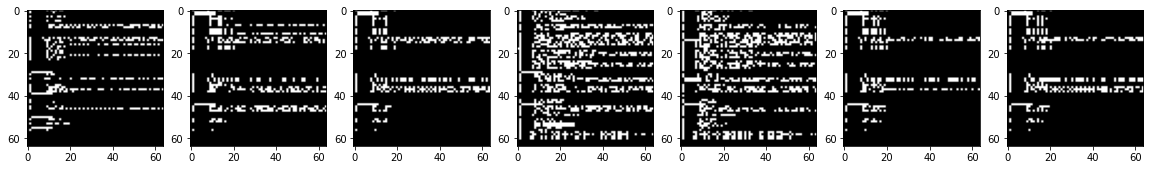

In [20]:
display_images(old_results, 7)

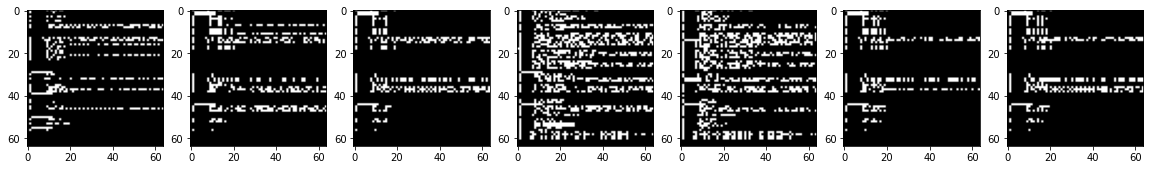

In [21]:
display_images(new_results, 7)

# Conversion with more functionality testing

In [80]:
def process_samples_as_floats(sample: List[float], precision: int, one: int, zero: int) -> List[List[int]]:
    """
    Takes a sample and returns a binary representation of the sample as a 2D list of 1s and 0s.
    
    Args:
        sample (List[float]): A list of features for a sample.
        
    Returns:
        List[List[int]]: A 2D list of 1s and 0s representing the binary values of the features in the sample.
    """
    sample_out = []
    for feature in sample:
        feature_out = [one if b == '1' else zero for b in bitstring.BitArray(float=feature, length=precision).bin]
        sample_out.append(feature_out)
    return sample_out

def process_samples_as_type(sample: List[float], precision: int, one: int, zero: int, feature_types : List = None) -> List[List[int]]:
    """
    Takes a sample and returns a binary representation of the sample as a 2D list of 1s and 0s.
    
    Args:
        sample (List[float]): A list of features for a sample.
        feature_types (List[int]): A list of integers representing the type of each feature in the dataframe.
        
    Returns:
        List[List[int]]: A 2D list of 1s and 0s representing the binary values of the features in the sample.
    """
    sample_out = []
    for i,feature in enumerate(sample):
        if feature_types[i] == 0: # floating point
            feature_out = [one if b == '1' else zero for b in bitstring.BitArray(float=feature, length=precision).bin]
        elif feature_types[i] == 1: # integer
            feature_out = [one if b == '1' else zero for b in bitstring.BitArray(int=int(feature), length=precision).bin]
        else: # boolean value
            if feature == True:
                feature_out = [one]*precision
            else:
                feature_out = [zero]*precision
        sample_out.append(feature_out)
    return sample_out

def convert_samples_to_binary_speedup(df: pd.DataFrame, precision: 32 or 64 = 64, one: int = 128, zero: int = 0, n_jobs: int = -1,
                                      feature_types : List[int] = None) -> np.ndarray:
    """
    Takes a pandas dataframe of numerical values and returns a binary representation of the dataframe as a matrix.
    
    Args:
        df (pd.DataFrame): The pandas dataframe to be converted to binary.
        precision (int): The number of bits to use when converting a feature to binary.
        one (int): The value to use when the binary representation of a feature contains a 1.
        zero (int): The value to use when the binary representation of a feature contains a 0.
        n_jobs (int): The number of processors to use when converting the dataframe to binary.
        feature_types (List[int]): A list of integers representing the type of each feature in the dataframe.
        
    Returns:
        ndarray: A ndarray representing the binary values of the features in the dataframe.
    """
    vals = df.values
    if feature_types == None:
        out = Parallel(n_jobs=n_jobs)(delayed(process_samples_as_floats)(sample, precision, one, zero) for sample in vals)     
    else:
        out = Parallel(n_jobs=n_jobs)(delayed(process_samples_as_type)(sample, precision, one, zero, feature_types) for sample in vals)
    return np.array(out, dtype=np.uint8)

In [95]:
df = read_dataframe('/mnt/sda1/all-cleaned-for-t2i.csv', 10)

In [85]:
df.iloc[0,-1] = True
df.iloc[0,-2] = 10349
df.iloc[0,-3] = 10349
df.head(1)

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Zero1,Zero2,Zero3
Index,,,,,,,,,,,,,,,,,,,,,
0-audio-streaming,86,True,0,77,0,46,0,25.666667,23.459184,0,...,0,1,32,0.0,0.0,0.0,0.0,10349,10349,True


In [86]:
feature_types = [0]*len(df.columns)
feature_types[-2] = 1
feature_types[-1] = 2
res = convert_samples_to_binary_speedup(df, precision=64, one=128, zero=0, n_jobs=-1, feature_types=feature_types)

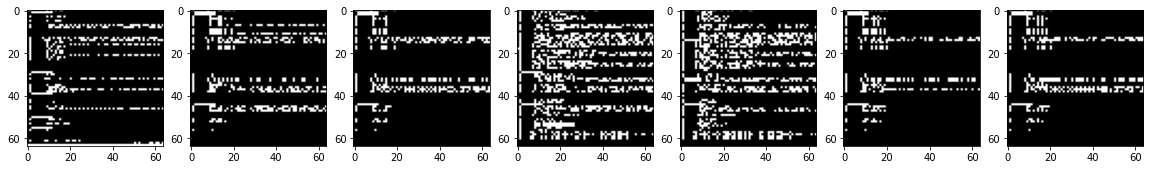

In [87]:
display_images(res, 7)

# Column type conversion testing

In [126]:
import pandas as pd

def get_column_data_types(df: pd.DataFrame) -> List[str]:
    """
    Given a pandas DataFrame, determine the data type of each column based on the types of its values.
    Returns a list of data types for each column in the DataFrame.

    Args:
        df: pandas.DataFrame The DataFrame to analyze.

    Returns:
        List[str]: A list of data types for each column in the DataFrame. Each data type is one of the following: 'float', 'int', 'bool', or 'other'.
    """
    col_types = []
    for col in df.columns:
        col_type = None
        for val in df[col]:
            val_type = type(val)
            if val_type == float:
                col_type = 'float'
            elif val_type == int:
                if col_type != None and (col_type == 'float' or col_type == 'other'):
                    break
                col_type = 'int'
            elif val_type == bool:
                if col_type != None and col_type != 'bool':
                    break
                col_type = 'bool'
            else:
                col_type = 'other'
                break
        
        col_types.append(col_type)
    
    return col_types

In [127]:
df = pd.DataFrame({'ints': [1, 2, 6, -1], 'floats': [1.0, 2.0, 6.0, -1.0], 'bools': [True, False, True, False], 'strings': ['a', 'b', 'c', 'd'],
                  'intAndFloats': [1, 2.0, 6, -1.0], 'intAndStrings': [1, 'b', 6, -1], 'floatAndStrings': [1.0, 'b', 6.0, -1.0],
                  'boolsAndStrings': [True, 'b', False, 'd'], 'boolsAndInts': [True, 2, False, -1], 'boolsAndFloats': [True, 2.0, False, -1.0]})
res = get_column_data_types(df)

In [128]:
correct_res = ['int', 'float', 'bool', 'other', 'float', 'other', 'other', 'other', 'int', 'float']
print(res == correct_res)

True
